## Setup

In [92]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## TidyCensus Example

This notebook grabs data from the US Census using the [tidycensus package in R](https://walker-data.com/tidycensus/index.html). Make sure you have installed the `tidyverse` and `tidycensus` packages.

In [94]:
%%R 

library(tidycensus)
library(tidyverse)

# store any shapefiles we grab from the census in ~/Library/Caches/tigris
# in case the government removes the shapefiles FTP server again 😭
options(tigris_use_cache = TRUE)

### Step 1 \| Load Census API key from `.env` file

The `.env` file should look like this:

```bash
CENSUS_API_KEY="your-api-key-here"
```

This is what is known as an environment variable. 

We load it below in Python

In [95]:
from dotenv import load_dotenv
load_dotenv() # <- searches for a file named .env and loads the environment variables in it

True

And in this cell we pass the environment variable to tidycensus in R

In [96]:
%%R 

census_api_key(Sys.getenv("CENSUS_API_KEY")) # <- Loads CENSUS_API_KEY from environment variable and sets it in R

To install your API key for use in future sessions, run this function with `install = TRUE`.


### Step 2 \| Figure out what tables you want data from and at what geographic granularity

Use <https://censusreporter.org/> to figure out which tables you want.

-   Scroll to the bottom of the page to see the tables.
-   If you already know the table ID, stick that in the "Explore" section to learn more about that table.

Note, you probably always want population variable (B01003_001) which we found in censusreporter here: https://censusreporter.org/tables/B01003/

- find some other variables that you're also interested in
- don't forget to pick a geography like "tract", "county" or "block group". here is the list of [all geographies](https://walker-data.com/tidycensus/articles/basic-usage.html#geography-in-tidycensus
).

👉 use the code from the example notebooks to get the variables you're interested in. feel free to use ChatGPT for help

In [106]:
%%R
library(tidycensus)

nyc_census_data <- get_acs(geography = "tract", 
                      state='NY',
                      county = c("New York", "Kings", "Queens", "Bronx", "Richmond"),
                      variables = c(
                        population="B01003_001",     # population
                        senior="B09020_001"
                        
                      ), 
                      year = 2022,
                      survey="acs5",
                      geometry=T)


  |======================================================================| 100%


Getting data from the 2018-2022 5-year ACS
Using FIPS code '36' for state 'NY'
Using FIPS code '061' for 'New York County'
Using FIPS code '047' for 'Kings County'
Using FIPS code '081' for 'Queens County'
Using FIPS code '005' for 'Bronx County'
Using FIPS code '085' for 'Richmond County'


### Step 3 | Pivot to Wide Format

Pivot from long to wide using `pivot_wider`.

Depending on what you're trying to do, you may want the data in long or wide format. This example pivots the data to wide format, which will help us with mapping later on in the notebook.

In [107]:
%%R 

nyc_census_data <- nyc_census_data %>% 
  pivot_wider(
    names_from=variable, 
    values_from = c(estimate, moe),
    names_glue = "{variable}_{.value}"
  ) # pivot from wide to long

nyc_census_data

Simple feature collection with 2327 features and 6 fields (with 3 geometries empty)
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -74.25563 ymin: 40.4961 xmax: -73.70036 ymax: 40.91771
Geodetic CRS:  NAD83
# A tibble: 2,327 × 7
   GEOID     NAME                   geometry population_estimate senior_estimate
   <chr>     <chr>        <MULTIPOLYGON [°]>               <dbl>           <dbl>
 1 36005013… Cens… (((-73.90508 40.82711, -…                3125             395
 2 36005009… Cens… (((-73.85773 40.83356, -…                5959             683
 3 36005005… Cens… (((-73.88389 40.82981, -…                5715             695
 4 36005036… Cens… (((-73.88832 40.84518, -…                4196             386
 5 36005044… Cens… (((-73.87136 40.90004, -…                2146             311
 6 36005017… Cens… (((-73.9157 40.83054, -7…                6116            1052
 7 36005021… Cens… (((-73.92222 40.83799, -…                 949             167
 8 36005007… Cens… (((

### Step 4 | Do calculations with `mutate`

In R, you can use `mutate` to create new columns or modify existing ones.

👉 In this step, do any calculations you need (for example if you have the total black population, but you want it as a percent of total population in a census tract, you may have to do some division)

In [114]:
%%R 
nyc_census_data <- nyc_census_data %>%
  mutate(
    borough = map_chr(str_split(NAME, ","), 1) %>% str_trim(),
    senior_pct = senior_estimate / population_estimate
  )


In [109]:
%%R
colnames(nyc_census_data)


[1] "GEOID"               "NAME"                "geometry"           
[4] "population_estimate" "senior_estimate"     "population_moe"     
[7] "senior_moe"         


### Step 5 | Example Plots

Use histograms or dotplots to view the distributions

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: Removed 85 rows containing non-finite outside the scale range (`stat_bin()`). 



Error in Ops.sfc(xi, xj) : operation > not supported


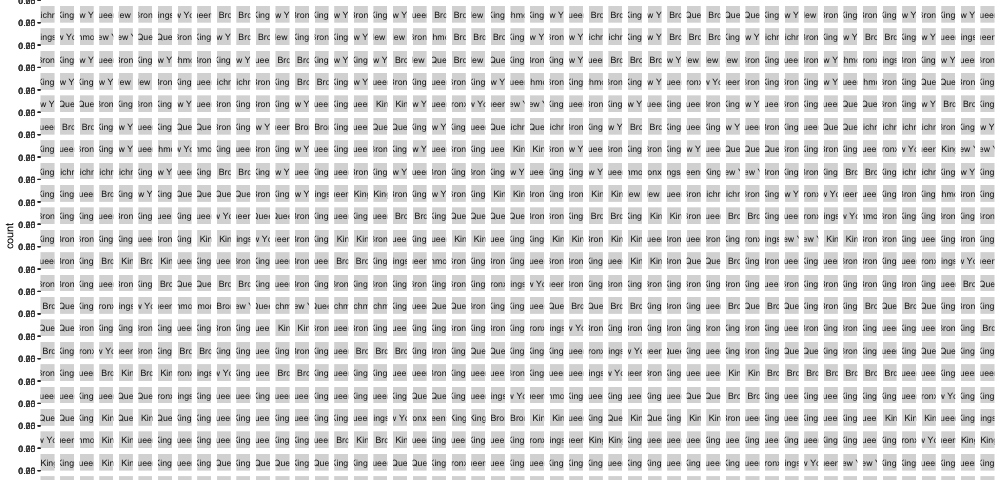

In [116]:
%%R -w 1000
ggplot(nyc_census_data) + 
    aes(x=senior_pct) +
    geom_histogram() + 
    facet_wrap(~borough) 


### Step 6 \| Example Map

See more details about making maps here:

https://walker-data.com/tidycensus/articles/spatial-data.html

In [117]:
%%R 

library(tigris)

# remove water from the shapefiles
# https://walker-data.com/tidycensus/articles/spatial-data.html
nyc_census_data <- nyc_census_data %>% 
    erase_water()

To enable caching of data, set `options(tigris_use_cache = TRUE)`
in your R script or .Rprofile.
Fetching area water data for your dataset's location...
Erasing water area...
If this is slow, try a larger area threshold value.


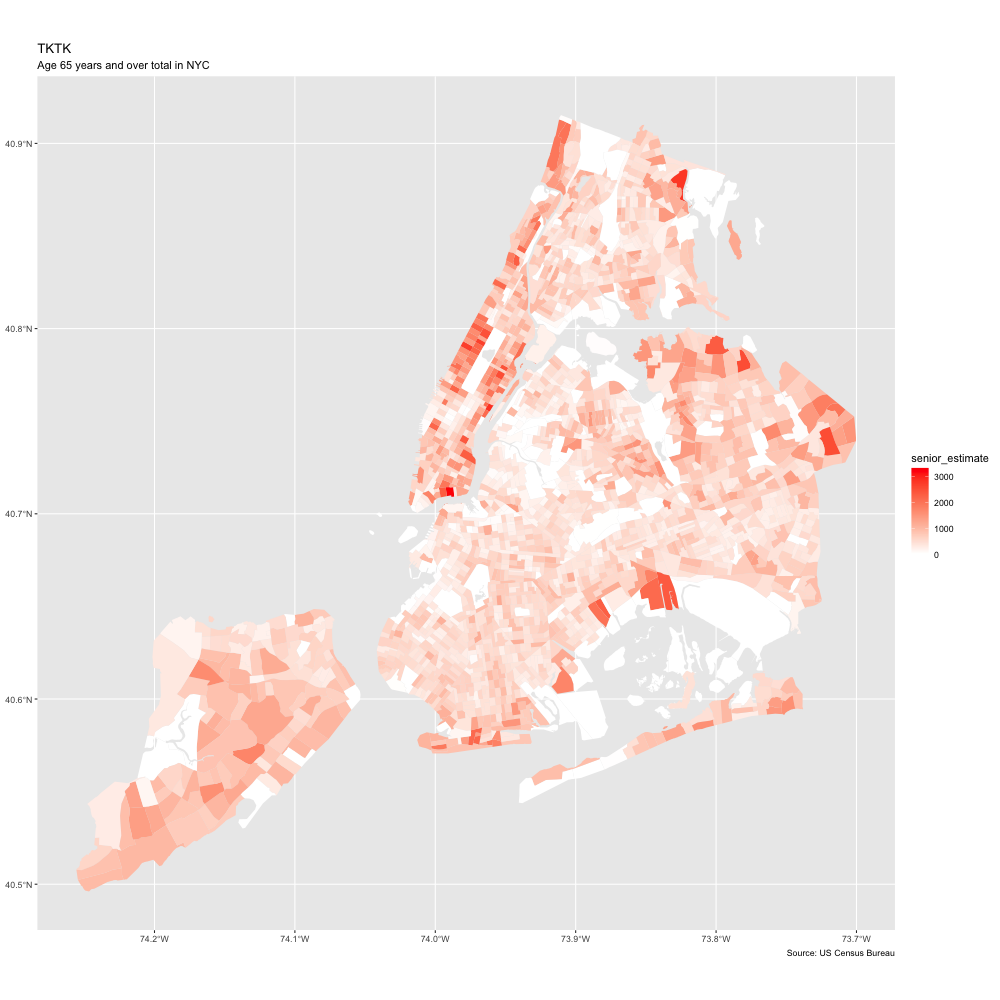

In [119]:
%%R -w 1000 -h 1000

nyc_census_data %>%
  ggplot(aes(fill = senior_estimate)) + 
  geom_sf(color = NA) + 
  scale_fill_gradient(low="white", high="red") + 
  labs(
    title = "TKTK",
    subtitle = "Age 65 years and over total in NYC",
    caption = "Source: US Census Bureau"
  )

